In [ ]:
   from google.colab import files
   uploaded = files.upload()  # Select your distraction_data.csv file

Saving distraction_data.csv to distraction_data.csv


In [ ]:
   !pip install pandas numpy scikit-learn xgboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle

# Load the data
data = pd.read_csv('distraction_data.csv')

# Basic data exploration
print(data.head())
print(f"Dataset shape: {data.shape}")
print("Number of rows:", len(data))

# Check for missing values
print("\nMissing values per column:")
print(data.isnull().sum())

# Fill missing values (if any)
# For numeric columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# For categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])

# Split features and target
X = data.drop(['fell_into_distraction', 'distraction_duration_minutes'], axis=1)
y = data['fell_into_distraction']

# Split categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical features: {categorical_features}")
print(f"Numeric features: {numeric_features}")

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# First split: 80% train, 20% temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: Split the temp into half validation and half test (each 10% of original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nTraining set size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set size: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Save the splits and preprocessing information
with open('data_splits.pkl', 'wb') as f:
    pickle.dump({
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test,
        'numeric_features': numeric_features,
        'categorical_features': categorical_features
    }, f)

print("\nData preparation completed and splits saved!")

  user_id            timestamp  time_of_day_hour day_of_week location  \
0  user_1  2023-01-01 18:15:25                18      Sunday   school   
1  user_1  2023-01-01 18:55:48                18      Sunday     cafe   
2  user_1  2023-01-01 23:30:54                23      Sunday     home   
3  user_1  2023-01-02 04:42:35                 4      Monday     cafe   
4  user_1  2023-01-02 06:37:48                 6      Monday     cafe   

  current_activity preceding_activity  productive_session_duration_minutes  \
0          working           studying                            36.136835   
1            break           exercise                             0.000000   
2    entertainment             social                             0.000000   
3            break            working                             0.000000   
4           social           studying                             0.000000   

   time_since_productive_activity_minutes  stress_level  ...  \
0                           

Loading prepared data splits...
Training set: 39939 samples
Validation set: 4992 samples
Test set: 4993 samples

Training the model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:12:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.57657	validation_1-logloss:0.57894
[1]	validation_0-logloss:0.49826	validation_1-logloss:0.50262
[2]	validation_0-logloss:0.43847	validation_1-logloss:0.44499
[3]	validation_0-logloss:0.39368	validation_1-logloss:0.40305
[4]	validation_0-logloss:0.36016	validation_1-logloss:0.36856
[5]	validation_0-logloss:0.33131	validation_1-logloss:0.33998
[6]	validation_0-logloss:0.30528	validation_1-logloss:0.31491
[7]	validation_0-logloss:0.28360	validation_1-logloss:0.29302
[8]	validation_0-logloss:0.26551	validation_1-logloss:0.27534
[9]	validation_0-logloss:0.25004	validation_1-logloss:0.26103
[10]	validation_0-logloss:0.23686	validation_1-logloss:0.24809
[11]	validation_0-logloss:0.22405	validation_1-logloss:0.23602
[12]	validation_0-logloss:0.21293	validation_1-logloss:0.22584
[13]	validation_0-logloss:0.20220	validation_1-logloss:0.21560
[14]	validation_0-logloss:0.19362	validation_1-logloss:0.20699
[15]	validation_0-logloss:0.18532	validation_1-logloss:0.19885
[1

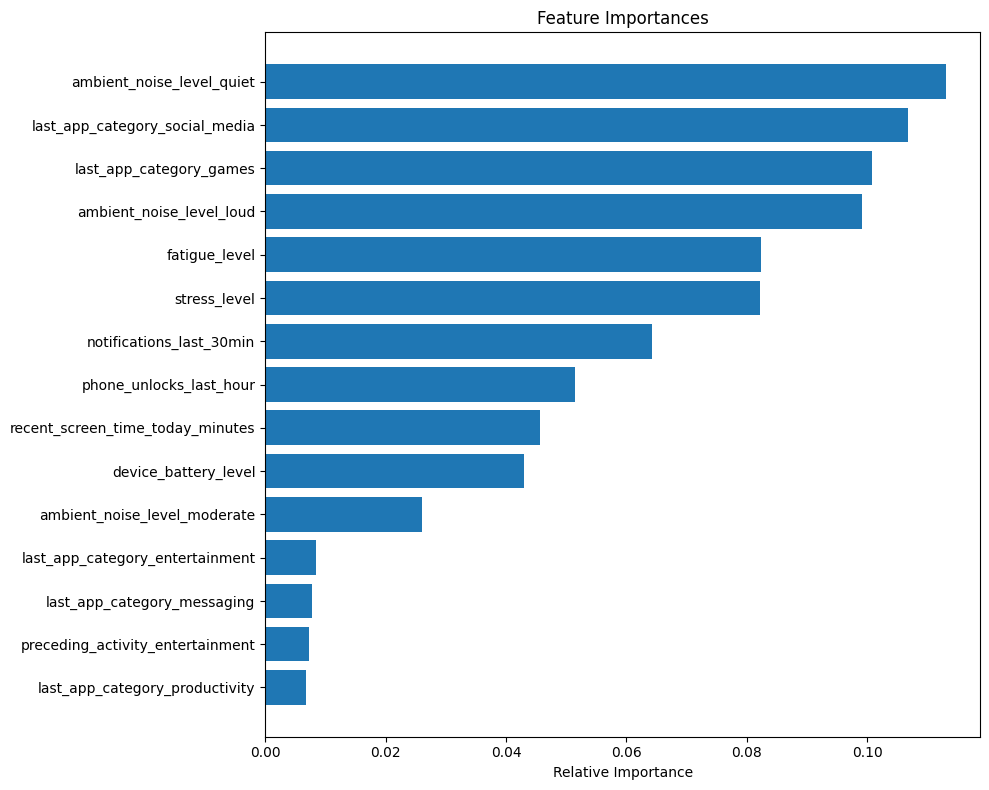

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt

# Load the prepared data splits
print("Loading prepared data splits...")
with open('data_splits.pkl', 'rb') as f:
    data_splits = pickle.load(f)

X_train = data_splits['X_train']
y_train = data_splits['y_train']
X_val = data_splits['X_val']
y_val = data_splits['y_val']
X_test = data_splits['X_test']
y_test = data_splits['y_test']
numeric_features = data_splits['numeric_features']
categorical_features = data_splits['categorical_features']

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Apply preprocessing to validation data for later use with early stopping
preprocessor_fit = preprocessor.fit(X_train)
X_val_transformed = preprocessor_fit.transform(X_val)

# Create XGBoost classifier with early stopping parameters
xgb_classifier = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    early_stopping_rounds=10,
    verbose=True
)

# Create and train model pipeline
print("\nTraining the model...")
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_classifier)
])

# Fit the model
X_train_preprocessed = preprocessor_fit.transform(X_train)
eval_set = [(X_train_preprocessed, y_train), (X_val_transformed, y_val)]
xgb_classifier.fit(X_train_preprocessed, y_train, eval_set=eval_set)

# Create the final pipeline with the trained components
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_fit),
    ('classifier', xgb_classifier)
])

# Make predictions on validation set
print("\nEvaluating on validation set...")
y_val_pred = final_pipeline.predict(X_val)
y_val_pred_proba = final_pipeline.predict_proba(X_val)[:, 1]

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation AUC:", roc_auc_score(y_val, y_val_pred_proba))
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Final evaluation on test set
print("\nFinal evaluation on test set...")
y_test_pred = final_pipeline.predict(X_test)
y_test_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred_proba))
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Save the model
with open('distraction_model.pkl', 'wb') as f:
    pickle.dump(final_pipeline, f)

# Save feature columns for later use in the application
with open('feature_columns.pkl', 'wb') as f:
    pickle.dump({'numeric': numeric_features, 'categorical': categorical_features}, f)

print("\nModel training completed and saved!")

# Plot feature importance
try:
    # Get feature importances
    xgb_model = xgb_classifier
    importances = xgb_model.feature_importances_

    # Get feature names
    feature_names = []

    # Get numeric feature names
    if len(numeric_features) > 0:
        feature_names.extend(numeric_features)

    # Get one-hot encoded feature names
    if len(categorical_features) > 0:
        for i, category in enumerate(categorical_features):
            ohe = preprocessor.transformers_[1][1]
            for category_value in ohe.categories_[i]:
                feature_names.append(f"{category}_{category_value}")

    # Keep only the number of features that match the importances length
    feature_names = feature_names[:len(importances)]

    # Plot top 15 features (or fewer if less available)
    n_features = min(15, len(importances))
    indices = np.argsort(importances)[-n_features:]

    plt.figure(figsize=(10, 8))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    print("Feature importance plot saved as 'feature_importance.png'")
except Exception as e:
    print(f"Could not generate feature importance plot: {e}")

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Copy files to Google Drive
import shutil
shutil.copy('distraction_model.pkl', '/content/drive/My Drive/')
shutil.copy('feature_columns.pkl', '/content/drive/My Drive/')

print("Files copied to Google Drive!")

Mounted at /content/drive
Files copied to Google Drive!
